In [1]:
%matplotlib inline

In [2]:
!pip install pyproj
!pip install cartopy


# NWS Precipitation Map


Plot a 1-day precipitation map using a netCDF file from the National Weather Service.

This opens the data directly in memory using the support in the netCDF library to open
from an existing memory buffer. In addition to CartoPy and Matplotlib, this uses
a custom colortable as well as MetPy's unit support.


Imports



In [3]:
from datetime import datetime, timedelta
from urllib.request import urlopen
!pip install metpy

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from metpy.units import masked_array, units
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Download the data from the National Weather Service.



In [4]:
dt = datetime.utcnow() - timedelta(days=1)  # This should always be available
print(dt)
url = 'http://water.weather.gov/precip/downloads/{dt:%Y/%m/%d}/nws_precip_1day_'\
      '{dt:%Y%m%d}_conus.nc'.format(dt=dt)
print(url)
data = urlopen(url).read()
#nc = Dataset('data', memory=data)
#data

2022-02-26 20:07:10.287649
http://water.weather.gov/precip/downloads/2022/02/26/nws_precip_1day_20220226_conus.nc


In [5]:

#file  = "./netcdf_file.nc"
nc = Dataset('data', memory=data)
#nc = Dataset(file)
#print(nc)

Pull the needed information out of the netCDF file



In [6]:
prcpvar = nc.variables['observation']
data = masked_array(prcpvar[:], units(prcpvar.units.lower())).to('mm')
x = nc.variables['x'][:]
y = nc.variables['y'][:]
proj_var = nc.variables[prcpvar.grid_mapping]

/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


In [7]:
#nc.variables
x

masked_array(data=[-1902530.61073866, -1897767.61073866,
                   -1893004.61073866, ...,  3422503.38926134,
                    3427266.38926134,  3432029.38926134],
             mask=False,
       fill_value=1e+20)

In [8]:
y

masked_array(data=[-3426165.19569394, -3430928.19569394,
                   -3435691.19569394, -3440454.19569394,
                   -3445217.19569394, -3449980.19569394,
                   -3454743.19569394, -3459506.19569394,
                   -3464269.19569394, -3469032.19569394,
                   -3473795.19569394, -3478558.19569394,
                   -3483321.19569394, -3488084.19569394,
                   -3492847.19569394, -3497610.19569394,
                   -3502373.19569394, -3507136.19569394,
                   -3511899.19569394, -3516662.19569394,
                   -3521425.19569394, -3526188.19569394,
                   -3530951.19569394, -3535714.19569394,
                   -3540477.19569394, -3545240.19569394,
                   -3550003.19569394, -3554766.19569394,
                   -3559529.19569394, -3564292.19569394,
                   -3569055.19569394, -3573818.19569394,
                   -3578581.19569394, -3583344.19569394,
                   -3588107.195

In [9]:
prcpvar = nc.variables['observation']
prcpvar

<class 'netCDF4._netCDF4.Variable'>
float32 observation(y, x)
    _FillValue: -3.4028235e+38
    proj4: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +units=m +no_defs
    grid_mapping: crs
    name: observation
    coordinates: time x y
    long_name: Observation
    units: Inches
    missing_value: -3.4028234663852886e+38
    esri_pe_string: PROJCS["NOAA_HRAP_Grid",    GEOGCS["GCS_NOAA_HRAP",        DATUM["D_NOAA_HRAP",            SPHEROID["Sphere",6371200,0.0]        ],        PRIMEM["Greenwich",0.0],        UNIT["Degree",0.0174532925199433]    ],    PROJECTION["Stereographic_North_Pole"],    PARAMETER["false_easting",0.0],    PARAMETER["false_northing",0.0],    PARAMETER["central_meridian",-105.0],    PARAMETER["standard_parallel_1",60.0],    UNIT["meter",1.0]]
unlimited dimensions: 
current shape = (881, 1121)
filling on

Set up the projection information within CartoPy



In [10]:
globe = ccrs.Globe(semimajor_axis=proj_var.earth_radius)
proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=proj_var.straight_vertical_longitude_from_pole,
                          true_scale_latitude=proj_var.standard_parallel, globe=globe)

Create the figure and plot the data
create figure and axes instances



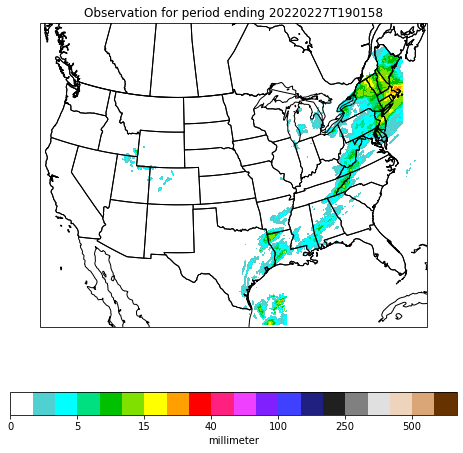

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=proj)

# draw coastlines, state and country boundaries, edge of map.
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.STATES)

# draw filled contours.
clevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40,
         50, 70, 100, 150, 200, 250, 300, 400, 500, 600, 750]
# In future MetPy
# norm, cmap = ctables.registry.get_with_boundaries('precipitation', clevs)
cmap_data = [(1.0, 1.0, 1.0),
             (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
             (0.0, 1.0, 1.0),
             (0.0, 0.8784313797950745, 0.501960813999176),
             (0.0, 0.7529411911964417, 0.0),
             (0.501960813999176, 0.8784313797950745, 0.0),
             (1.0, 1.0, 0.0),
             (1.0, 0.6274510025978088, 0.0),
             (1.0, 0.0, 0.0),
             (1.0, 0.125490203499794, 0.501960813999176),
             (0.9411764740943909, 0.250980406999588, 1.0),
             (0.501960813999176, 0.125490203499794, 1.0),
             (0.250980406999588, 0.250980406999588, 1.0),
             (0.125490203499794, 0.125490203499794, 0.501960813999176),
             (0.125490203499794, 0.125490203499794, 0.125490203499794),
             (0.501960813999176, 0.501960813999176, 0.501960813999176),
             (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
             (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
             (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
             (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
             (0.4000000059604645, 0.20000000298023224, 0.0)]
cmap = mcolors.ListedColormap(cmap_data, 'precipitation')
norm = mcolors.BoundaryNorm(clevs, cmap.N)

cs = ax.contourf(x, y, data, clevs, cmap=cmap, norm=norm)

# add colorbar.
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label(data.units)

ax.set_title(prcpvar.long_name + ' for period ending ' + nc.creation_time)
plt.show()

In [12]:
plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [13]:
!pip install tensorflow

In [14]:
import tensorflow as tf
import numpy as np

def serialize_array( array):
    array = tf.io.serialize_tensor(array)
    return array

def bytes_feature( value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))): # if value ist tensor
            value = value.numpy() # get value of tensor
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def int64_feature( value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
    
def float_feature( value):
        """Returns a float_list from a float / double."""
        
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def float_feature_Array( value):
        """Returns a float_list from a float / double."""
        #print('cov')
        return tf.train.Feature(float_list=tf.train.FloatList(value=value))
    
def create_tfrecord( example, metadata,coord): 
    feature = {
        "radar": bytes_feature(serialize_array(example)), # tf.string
        "sample_prob": float_feature(1.),  # tf.float32
        "central_latitude":int64_feature(int(90.0)),
        "central_longitude":int64_feature(int(metadata.straight_vertical_longitude_from_pole)),
        "true_scale_latitude":int64_feature(int(metadata.standard_parallel)),
        "earth_radius":int64_feature(int(metadata.earth_radius)),
        "x":bytes_feature(serialize_array(coord[0])),#float_feature_Array(coord[0]),
        "y":bytes_feature(serialize_array(coord[1])) #float_feature_Array(coord[1])
        #metadata.earth_radius#,
        #"lonmin": int64_feature(metadata[0].latlong_box[0]), # tf.int64
        #"lonmax": int64_feature(metadata[0].latlong_box[1]), # tf.int64
        #"latmin": int64_feature(metadata[0].latlong_box[2]), # tf.int64
        #"latmax": int64_feature(metadata[0].latlong_box[3]), # tf.int64
        #"end_time_timestamp": int64_feature(int(dt.timestamp)), # tf.int64
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

def save_as_tfrecord( path, arr):
    # Convert arr (list of GoesImages) to tfrecord format
    # Concat all timesteps into one np array
    #radar_frames = np.empty((0,256,256,arr[0].num_bands))
    #for goes_image in arr:
    #    radar_frames = np.append(radar_frames, np.expand_dims(goes_image.img, axis=0), axis=0)
    prcpvar = arr.variables['observation']
    radar_frames = masked_array(prcpvar[:], units(prcpvar.units.lower())).to('mm')
    proj_var = arr.variables[prcpvar.grid_mapping]
    
    coord = ( arr.variables["x"][:],  arr.variables["y"][:] )
    #tfoptions = tf.io.TFRecordOptions(2) # 2 = GZIP
    tfoptions = tf.io.TFRecordOptions(compression_type="GZIP")
    
    #creation_time =   arr.creation_time

    with tf.io.TFRecordWriter(path +".tfrecord.gz", options=tfoptions) as writer:
        tfrecord = create_tfrecord(radar_frames, proj_var,coord)
        serialized_tfrecord = tfrecord.SerializeToString()
        writer.write(serialized_tfrecord)

In [15]:
prcpvar = nc.variables['observation']
prcpvar

<class 'netCDF4._netCDF4.Variable'>
float32 observation(y, x)
    _FillValue: -3.4028235e+38
    proj4: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +units=m +no_defs
    grid_mapping: crs
    name: observation
    coordinates: time x y
    long_name: Observation
    units: Inches
    missing_value: -3.4028234663852886e+38
    esri_pe_string: PROJCS["NOAA_HRAP_Grid",    GEOGCS["GCS_NOAA_HRAP",        DATUM["D_NOAA_HRAP",            SPHEROID["Sphere",6371200,0.0]        ],        PRIMEM["Greenwich",0.0],        UNIT["Degree",0.0174532925199433]    ],    PROJECTION["Stereographic_North_Pole"],    PARAMETER["false_easting",0.0],    PARAMETER["false_northing",0.0],    PARAMETER["central_meridian",-105.0],    PARAMETER["standard_parallel_1",60.0],    UNIT["meter",1.0]]
unlimited dimensions: 
current shape = (881, 1121)
filling on

In [16]:
proj_var = nc.variables[prcpvar.grid_mapping]
data = masked_array(prcpvar[:], units(prcpvar.units.lower())).to('mm')
data

/opt/conda/lib/python3.9/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=-3.4028235e+38,
  dtype=float32) <Unit('millimeter')>

In [17]:
globe = ccrs.Globe(semimajor_axis=proj_var.earth_radius)
proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=proj_var.straight_vertical_longitude_from_pole,
                          true_scale_latitude=proj_var.standard_parallel, globe=globe) 

In [18]:
#"lonmin": int64_feature(metadata[0].latlong_box[0]), # tf.int64
#"lonmax": int64_feature(metadata[0].latlong_box[1]), # tf.int64
#"latmin": int64_feature(metadata[0].latlong_box[2]), # tf.int64
#"latmax": int64_feature(metadata[0].latlong_box[3]), # tf.int64
#"end_time_timestamp": int64_feature(int(metadata[len(metadata) - 1].timestamp))

nc.variables 
#proj_var.straight_vertical_longitude_from_pole

{'time': <class 'netCDF4._netCDF4.Variable'>
 int32 time()
     units: seconds since 1970-01-01
     long_name: The date of precipitation accumulation data which this netCDF contains
     standard_name: time
     calendar: standard
     axis: T
 unlimited dimensions: 
 current shape = ()
 filling on, default _FillValue of -2147483647 used,
 'crs': <class 'netCDF4._netCDF4.Variable'>
 int32 crs()
     straight_vertical_longitude_from_pole: -105.0
     false_easting: 0.0
     standard_parallel: 60.0
     false_northing: 0.0
     grid_mapping_name: polar_stereographic
     latitude_of_projection_origin: 90.0
     earth_radius: 6371200.0
     proj4: +proj=stere +lat_0=90 +lat_ts=60 +lon_0=-105 +x_0=0 +y_0=0 +a=6371200 +b=6371200 +units=m +no_defs
     crs_wkt: PROJCS["NOAA_HRAP_Grid",    GEOGCS["GCS_NOAA_HRAP",        DATUM["D_NOAA_HRAP",            SPHEROID["Sphere",6371200,0.0]        ],        PRIMEM["Greenwich",0.0],        UNIT["Degree",0.0174532925199433]    ],    PROJECTION["Polar_S

In [19]:
save_as_tfrecord(dt.strftime('%d_%m_%Y') +"_prepMap", nc)

2022-02-27 20:07:35.700622: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
